In [1]:
import os
import pandas as pd
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import Holt

In [12]:
data_dir=r"your direction"


files=[file for file in os.listdir(data_dir) if file.endswith('.csv')]

dfs=[]

for file in files:
    file_path=os.path.join(data_dir,file)
    df=pd.read_csv(file_path)
    print(f"{file}: {len(df)} rows, {len(df.columns)} columns")
    dfs.append(df)
    
all_data=pd.concat(dfs,ignore_index=True)

all_data.head()

Sales_April_2019.csv: 18383 rows, 6 columns
Sales_August_2019.csv: 12011 rows, 6 columns
Sales_December_2019.csv: 25117 rows, 6 columns
Sales_February_2019.csv: 12036 rows, 6 columns
Sales_January_2019.csv: 9723 rows, 6 columns
Sales_July_2019.csv: 14371 rows, 6 columns
Sales_June_2019.csv: 13622 rows, 6 columns
Sales_March_2019.csv: 15226 rows, 6 columns
Sales_May_2019.csv: 16635 rows, 6 columns
Sales_November_2019.csv: 17661 rows, 6 columns
Sales_October_2019.csv: 20379 rows, 6 columns
Sales_September_2019.csv: 11686 rows, 6 columns


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [9]:
# Calculate the percentage of null values per column
null_percentage = all_data.isnull().mean() * 100
print(null_percentage)


Order ID            0.291678
Product             0.291678
Quantity Ordered    0.291678
Price Each          0.291678
Order Date          0.291678
Purchase Address    0.291678
dtype: float64


In [13]:
all_data=all_data.dropna()

In [17]:
all_data.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,186305,186305,186305,186305,186305,186305
unique,178438,20,10,24,142396,140788
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,355,21903,168552,21903,355,355


In [22]:
# Identify rows with invalid "Order Date" entries
invalid_date_entries = all_data[~all_data['Order Date'].str.contains(r'\d{2}/\d{2}/\d{2} \d{2}:\d{2}', na=False)]
invalid_date_entries


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
519,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1149,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1155,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2878,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2893,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
...,...,...,...,...,...,...
185164,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
185551,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
186563,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
186632,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


## 1.  Sales Over Time

Month
2019-01    1803264.98
2019-02    2188884.72
2019-03    2791207.83
2019-04    3367671.02
2019-05    3135125.13
Freq: M, Name: Price Each, dtype: float64


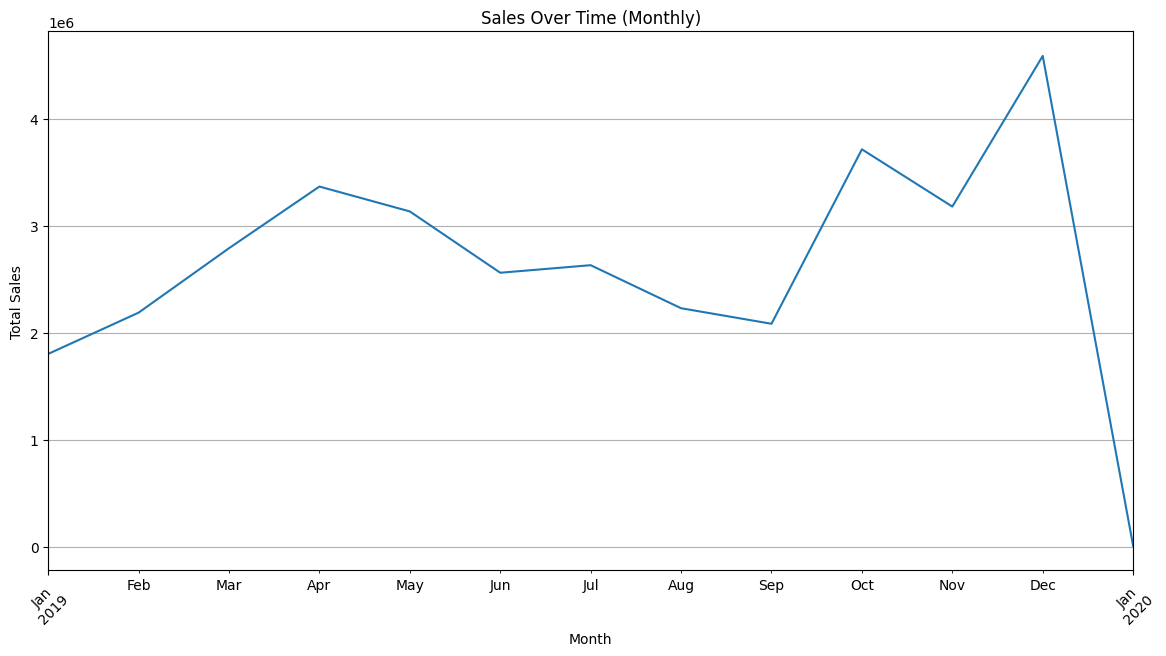

In [28]:
# Ensure proper datetime conversion and extract month-year for better aggregation
all_data['Order Date'] = pd.to_datetime(all_data['Order Date'])
all_data['Month'] = all_data['Order Date'].dt.to_period('M')

# Convert 'Price Each' to numeric, forcing errors to NaN (and dropping them later)
all_data['Price Each'] = pd.to_numeric(all_data['Price Each'], errors='coerce')

# Drop rows with NaN in 'Price Each'
all_data = all_data.dropna(subset=['Price Each'])

# Aggregate by month with proper numeric sum
sales_over_time_monthly = all_data.groupby('Month')['Price Each'].sum()

# Verify the aggregation
print(sales_over_time_monthly.head())

# Plot the resampled sales over time
plt.figure(figsize=(14, 7))
sales_over_time_monthly.plot()
plt.title('Sales Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# 2. Item Popularity

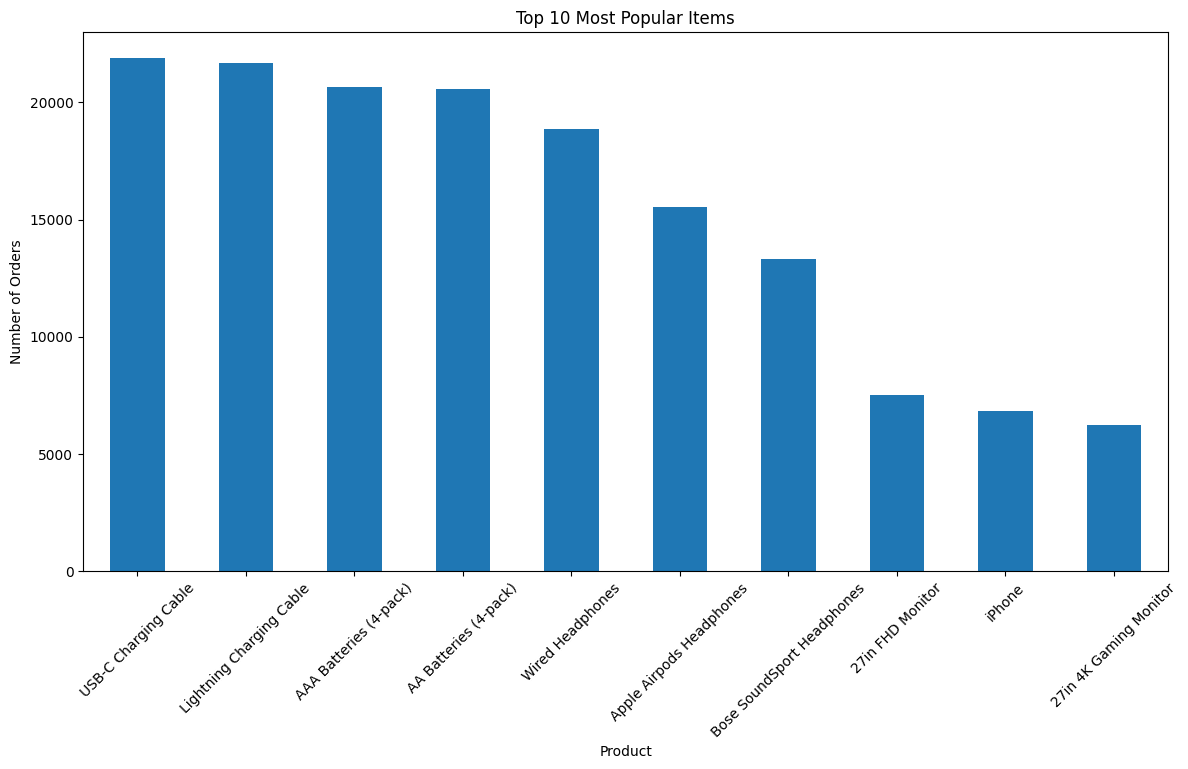

In [30]:
# Group by product and count the number of orders
item_popularity = all_data['Product'].value_counts().head(10)

# Plot the item popularity
plt.figure(figsize=(14, 7))
item_popularity.plot(kind='bar')
plt.title('Top 10 Most Popular Items')
plt.xlabel('Product')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


## 3. Customer Segmentation based on their purchase

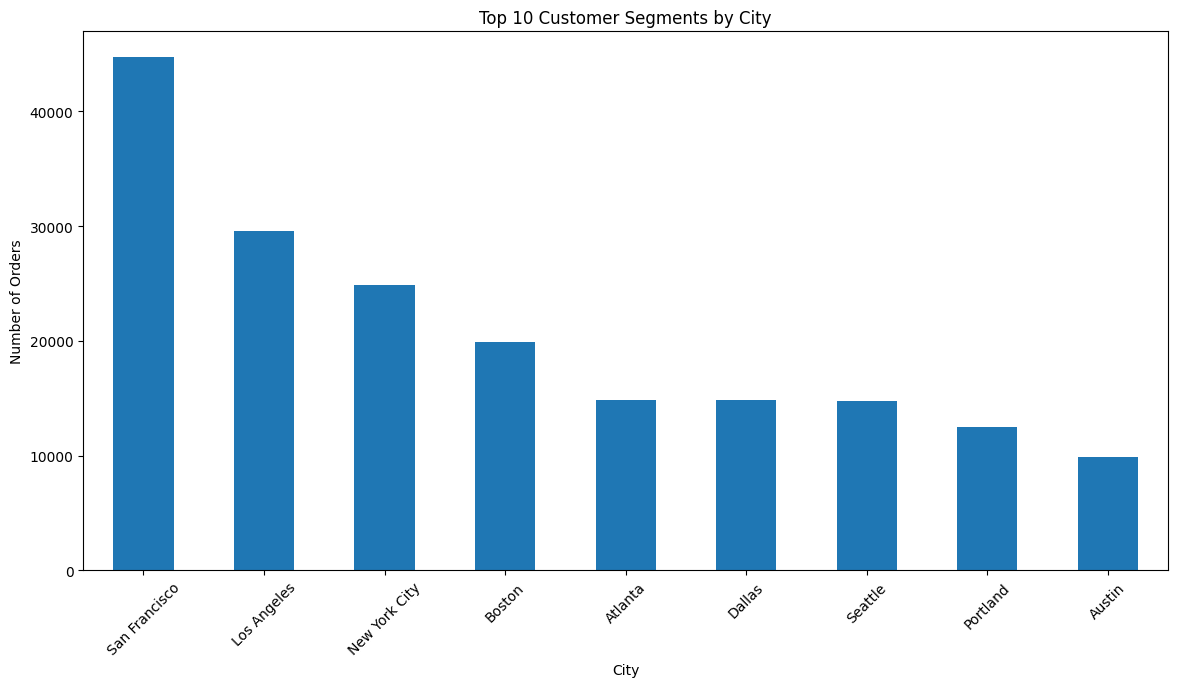

In [33]:
# Extract relevant customer information from the 'Purchase Address'
all_data['City'] = all_data['Purchase Address'].apply(lambda x: x.split(',')[1].strip())
customer_segments = all_data['City'].value_counts().head(10)

# Plot the customer segments
plt.figure(figsize=(14, 7))
customer_segments.plot(kind='bar')
plt.title('Top 10 Customer Segments by City')
plt.xlabel('City')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


# 4. daily order time

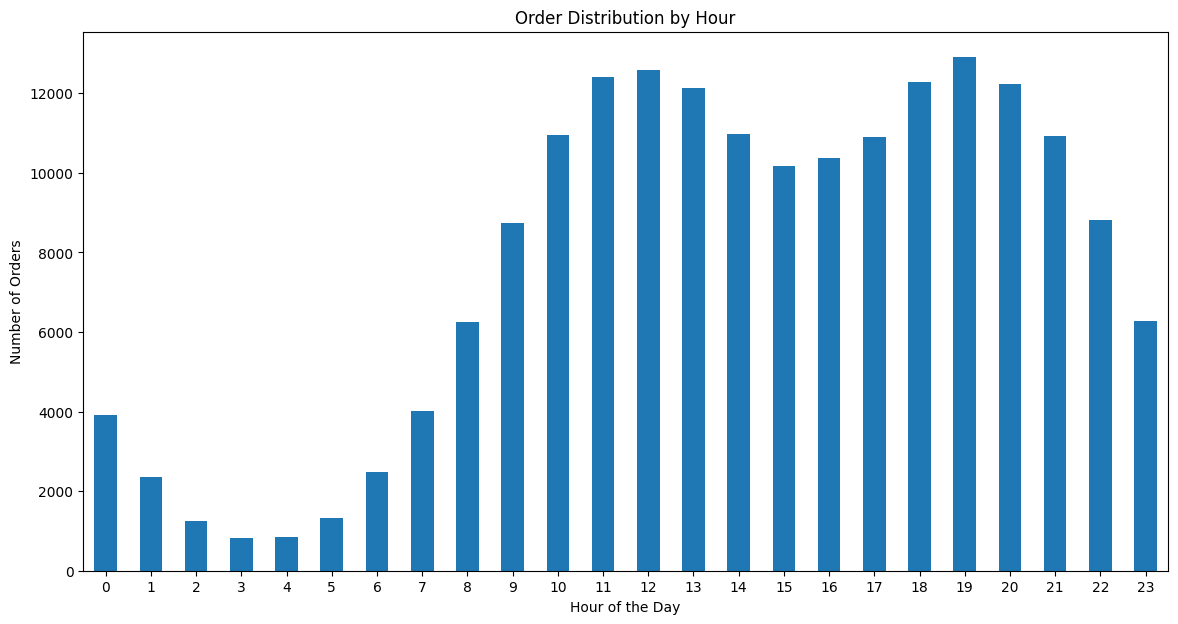

In [38]:
all_data['Time'] = all_data['Order Date'].dt.hour

order_time = all_data['Time'].value_counts().sort_index()

# Plot the order time distribution
plt.figure(figsize=(14, 7))
order_time.plot(kind='bar')
plt.title('Order Distribution by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.show()

# 5. sales forecasting with two models

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


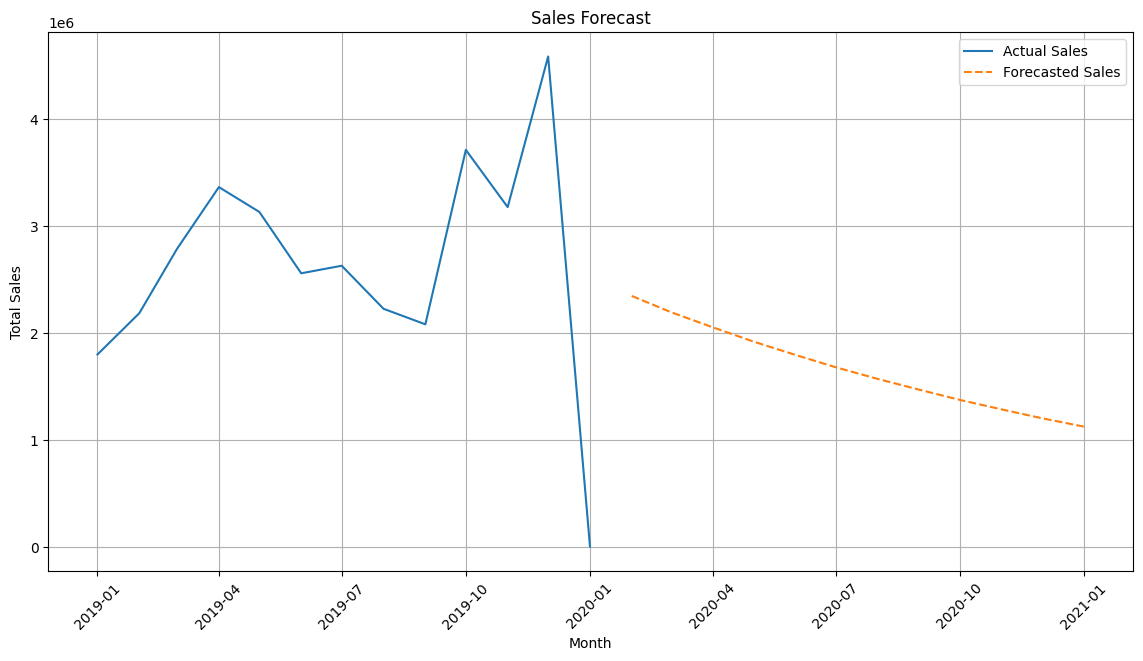

In [48]:
# Create a time series model without seasonal component
model = Holt(sales_over_time_monthly, exponential=True)
fit = model.fit()
forecast = fit.forecast(12)  # Forecasting for the next 12 months

# Plot the sales forecast
plt.figure(figsize=(14, 7))
plt.plot(sales_over_time_monthly.index, sales_over_time_monthly.values, label='Actual Sales')
plt.plot(forecast.index, forecast.values, label='Forecasted Sales', linestyle='--')
plt.title('Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


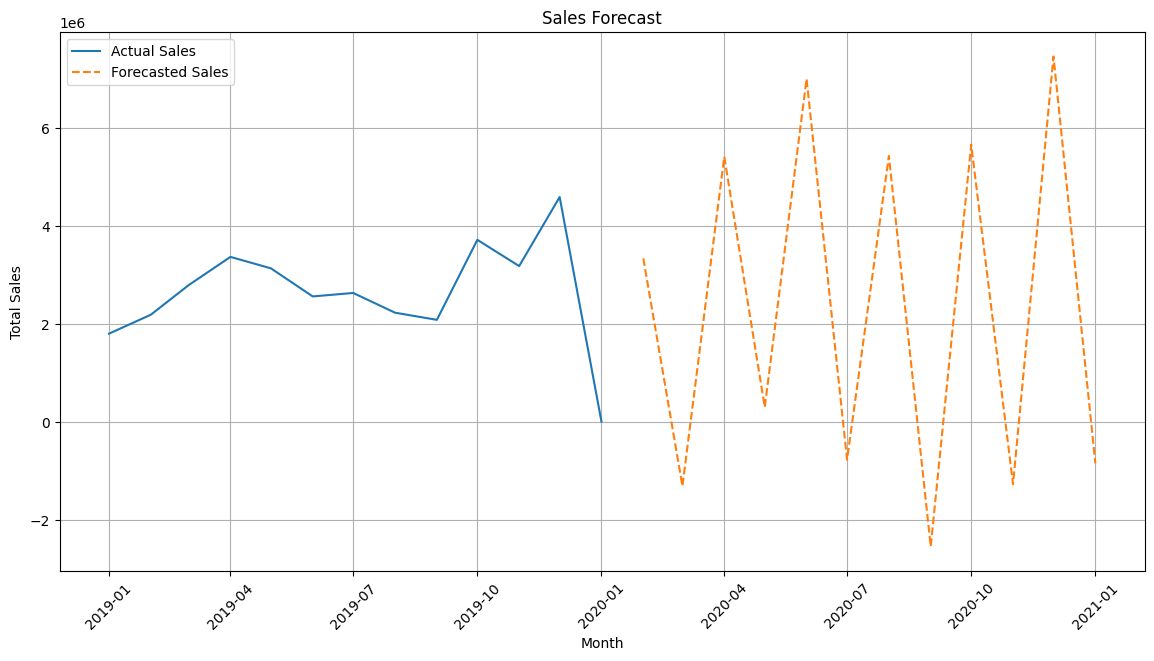

In [45]:
sales_over_time_monthly.index = sales_over_time_monthly.index.to_timestamp()

model = ARIMA(sales_over_time_monthly, order=(5, 1, 0))
fit = model.fit()
forecast = fit.forecast(steps=12)  # Forecasting for the next 12 months

# Plot the sales forecast
plt.figure(figsize=(14, 7))
plt.plot(sales_over_time_monthly.index, sales_over_time_monthly.values, label='Actual Sales')
plt.plot(forecast.index, forecast.values, label='Forecasted Sales', linestyle='--')
plt.title('Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# 6. Customer Segmentation with Clustring

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


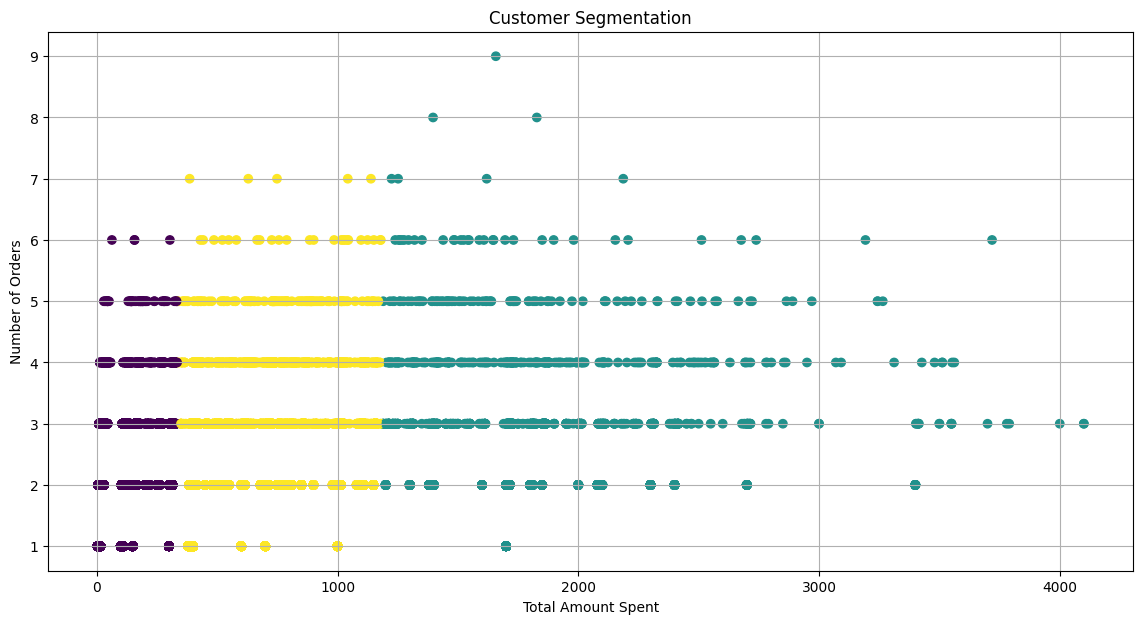

In [41]:

# total amount spent and number of orders
customer_summary = all_data.groupby('Purchase Address').agg({'Price Each': 'sum', 'Order ID': 'count'}).rename(columns={'Price Each': 'TotalSpent', 'Order ID': 'OrderCount'})

# Apply K-means clustering
kmeans = KMeans(n_clusters=3)
customer_summary['Cluster'] = kmeans.fit_predict(customer_summary)

# Plot the customer segments
plt.figure(figsize=(14, 7))
plt.scatter(customer_summary['TotalSpent'], customer_summary['OrderCount'], c=customer_summary['Cluster'], cmap='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Total Amount Spent')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()


# 7. Recommendation System

In [58]:
user_item_matrix = all_data.pivot_table(index='Purchase Address', columns='Product', values='Quantity Ordered', aggfunc='sum', fill_value=0)
user_item_matrix = user_item_matrix.apply(pd.to_numeric, errors='coerce')

In [59]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD
svd = TruncatedSVD(n_components=19)
matrix = svd.fit_transform(user_item_matrix)

# Compute user-item scores
user_item_scores = pd.DataFrame(matrix, index=user_item_matrix.index)


In [60]:
def recommend_items(user, user_item_scores, user_item_matrix, top_n=5):
    user_scores = user_item_scores.loc[user].values.reshape(1, -1)
    similarity_scores = np.dot(user_item_scores, user_scores.T)
    similar_users = similarity_scores.flatten().argsort()[-top_n:]
    
    recommended_items = {}
    for similar_user in similar_users:
        similar_user_items = user_item_matrix.iloc[similar_user]
        for item, score in similar_user_items.items():
            if item not in recommended_items:
                recommended_items[item] = score
            else:
                recommended_items[item] += score
                
    recommended_items = sorted(recommended_items.items(), key=lambda x: x[1], reverse=True)
    return [item[0] for item in recommended_items if item[1] > 0][:top_n]

# Example usage with a valid user purchase address
valid_user = user_item_matrix.index[0]
recommendations = recommend_items(valid_user, user_item_scores, user_item_matrix)
print("Recommended items for user:", recommendations)

Recommended items for user: ['USB-C Charging Cable', 'Apple Airpods Headphones', 'Bose SoundSport Headphones', 'Wired Headphones']
